## Question 4

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import scikitplot as skplt

In [2]:
df = pd.read_csv('face.csv')
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,target
0,0.309917,0.367769,0.417355,0.442149,0.528926,0.607438,0.657025,0.677686,0.690083,0.685950,...,0.669422,0.652893,0.661157,0.475207,0.132231,0.148760,0.152893,0.161157,0.157025,0
1,0.454545,0.471074,0.512397,0.557851,0.595041,0.640496,0.681818,0.702479,0.710744,0.702479,...,0.157025,0.136364,0.148760,0.152893,0.152893,0.152893,0.152893,0.152893,0.152893,0
2,0.318182,0.400826,0.491736,0.528926,0.586777,0.657025,0.681818,0.685950,0.702479,0.698347,...,0.132231,0.181818,0.136364,0.128099,0.148760,0.144628,0.140496,0.148760,0.152893,0
3,0.198347,0.194215,0.194215,0.194215,0.190083,0.190083,0.243802,0.404959,0.483471,0.516529,...,0.636364,0.657025,0.685950,0.727273,0.743802,0.764463,0.752066,0.752066,0.739669,0
4,0.500000,0.545455,0.582645,0.623967,0.648760,0.690083,0.694215,0.714876,0.723140,0.731405,...,0.161157,0.177686,0.173554,0.177686,0.177686,0.177686,0.177686,0.173554,0.173554,0
5,0.549587,0.545455,0.541322,0.537190,0.537190,0.533058,0.528926,0.533058,0.590909,0.611570,...,0.619835,0.623967,0.615702,0.661157,0.661157,0.690083,0.714876,0.706612,0.702479,0
6,0.330578,0.305785,0.330578,0.351240,0.425620,0.500000,0.603306,0.632231,0.644628,0.644628,...,0.541322,0.541322,0.524793,0.537190,0.487603,0.190083,0.144628,0.152893,0.152893,0
7,0.128099,0.185950,0.247934,0.314050,0.388430,0.462810,0.520661,0.557851,0.590909,0.623967,...,0.157025,0.165289,0.148760,0.157025,0.157025,0.152893,0.152893,0.173554,0.173554,0
8,0.243802,0.297521,0.367769,0.454545,0.495868,0.537190,0.578512,0.603306,0.611570,0.632231,...,0.669422,0.537190,0.235537,0.169422,0.177686,0.190083,0.190083,0.181818,0.190083,0
9,0.380165,0.442149,0.483471,0.545455,0.582645,0.628099,0.648760,0.677686,0.690083,0.710744,...,0.157025,0.165289,0.148760,0.165289,0.173554,0.173554,0.173554,0.173554,0.173554,0


In [3]:
train_data = pd.concat([df.iloc[i*10+2:(i+1)*10] for i in range(40)])
train_data.reset_index(drop=True,inplace=True)

test_data = pd.concat([df.iloc[i*10:i*10+2] for i in range(40)])
test_data.reset_index(drop=True,inplace=True)

In [4]:
# remove target column
X = train_data.iloc[:,:-1]

threshold = 0.95

mean_ = np.mean(X, axis=0)

# Centering the data
X_meaned = X - mean_

# Calculating the covariance matrix of the mean-centered data
cov_mat = np.cov(X_meaned , rowvar = False)

# Calculating Eigenvalues and Eigenvectors of the covariance matrix
eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)

# Sort the eigenvalues in descending order
sorted_index = np.argsort(eigen_values)[::-1]
sorted_eigenvalue = eigen_values[sorted_index].astype(np.float64)

# Similarly sort the eigenvectors 
sorted_eigenvectors = eigen_vectors[:,sorted_index]

# calculate the percentage of explained variance per principal component
cumul_eigenvalue = sorted_eigenvalue.cumsum()
cumul_on_total = cumul_eigenvalue / cumul_eigenvalue[-1]

num_components = 0
while(cumul_on_total[num_components] < threshold):
    num_components += 1
num_components += 1

print('The number of features have been reduced from {} to {} for a threshold of {}% variance.'.format(X.shape[1],num_components,threshold*100))

eigenvector_subset = sorted_eigenvectors[:, 0:num_components]

# Transform the data 
X_reduced = np.dot(eigenvector_subset.transpose(), X_meaned.transpose()).transpose()

The number of features have been reduced from 4096 to 111 for a threshold of 95.0% variance.


In [5]:
principal_df = pd.DataFrame(X_reduced , columns = ['col'+str(i) for i in range(1,num_components+1)])
principal_df = pd.concat([principal_df , train_data['target']] , axis = 1)

In [6]:
classifier = GaussianNB()
classifier.fit(principal_df[['col'+str(i) for i in range(1,num_components+1)]], principal_df["target"])

GaussianNB()

In [7]:
test_reduced = (eigenvector_subset.T @ (test_data.iloc[:,:-1] - mean_).T).T
predicted = classifier.predict(test_reduced)
test_reduced = pd.concat([test_reduced, test_data['target']], axis = 1)

In [8]:
test_reduced['predicted'] = predicted
acc = []
for i in range(len(test_reduced)):
    if test_reduced['target'][i] == test_reduced['predicted'][i]:
        acc.append("correct")
    else:
        acc.append("wrong")

test_reduced["correctness"] = acc
x = accuracy_score(test_reduced["target"], predicted)
print("Accuracy =",x*100,"%")

Accuracy = 97.5 %


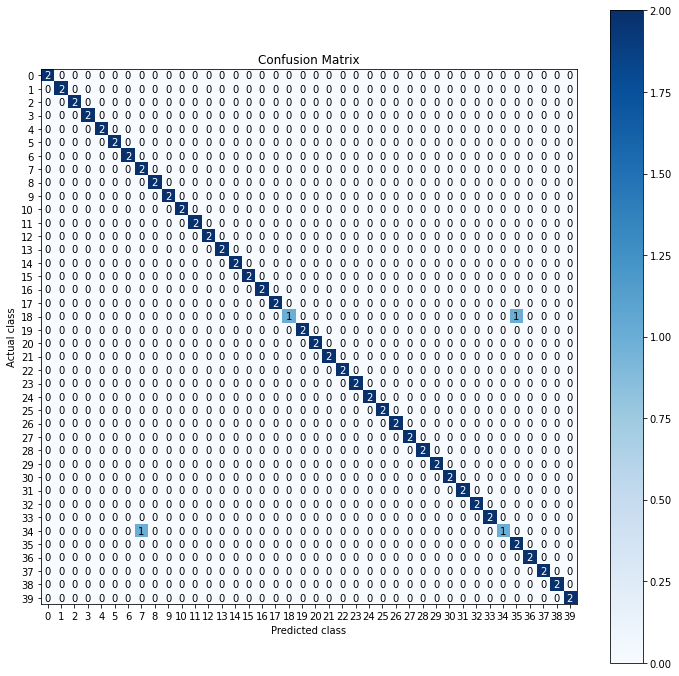

In [13]:
skplt.metrics.plot_confusion_matrix(test_reduced["target"], predicted, figsize=(12,12))
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.show()